# `vaex` @ EuroPython 2019

## New York Taxi Dataset (2009-2015): Exploratory Data Analysis and Machine Learning example (part 2/3)

In [1]:
import vaex
from vaex.ui.colormaps import cm_plusmin

import numpy as np

import pylab as p
import seaborn as sns

### Open the dataset

In [2]:
# Opens the data
df = vaex.open('./data/yellow_taxi_2009_2015_f32.hdf5')

# Check length
print('Number of samples in the data: %i' % len(df))

Number of samples in the data: 1173057927


In [3]:
# View a portion of the dataset
df.head_and_tail_print()

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.630000114440918,-73.99195861816406,40.72156524658203,nan,nan,-73.99380493164062,40.6959228515625,8.899999618530273,0.5,nan,0.0,0.0,9.399999618530273
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.550000190734863,-73.98210144042969,40.736289978027344,nan,nan,-73.95584869384766,40.768028259277344,12.100000381469727,0.5,nan,2.0,0.0,14.600000381469727
2,VTS,2009-01-03 15:43:00.000000000,2009-01-03 15:57:00.000000000,5,Credit,10.350000381469727,-74.0025863647461,40.73974609375,nan,nan,-73.86997985839844,40.770225524902344,23.700000762939453,0.0,nan,4.739999771118164,0.0,28.440000534057617
3,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5.0,-73.9742660522461,40.79095458984375,nan,nan,-73.9965591430664,40.731849670410156,14.899999618530273,0.5,nan,3.049999952316284,0.0,18.450000762939453
4,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4000000059604645,-74.00157928466797,40.719383239746094,nan,nan,-74.00837707519531,40.7203483581543,3.700000047683716,0.0,nan,0.0,0.0,3.700000047683716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,173,057,922",VTS,2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,1,1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167
"1,173,057,923",CMT,2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,2,2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863
"1,173,057,924",CMT,2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,2,3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863
"1,173,057,925",VTS,2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,2,1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863


### Split the data into train & test sets

In [4]:
# Train / test split (by date)
df_train = df[:1_026_944_937]
df_test = df[1_026_944_937:]

print('Number of samples in the training set: %i' % len(df_train))
print('Number of samples in the test set: %i' % len(df_test))

# Check if the lengths of the datasets match
assert len(df) == len(df_test) + len(df_train)

Number of samples in the training set: 1026944937
Number of samples in the test set: 146112990


### Basic view in the contents of the data

In [5]:
# Basic description about the training dataset
df_train.describe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
dtype,str,datetime64[ns],datetime64[ns],int64,str,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
count,1026944937,1026944937,1026944937,1026944937,1026944937,1026944937,1026944937,1026944936,856048881,492801449,1026930442,1026937251,1026944936,1026944936,885904367,1026944936,1026944936,1026944936
NA,0,0,0,0,0,0,0,1,170896056,534143488,14495,7686,1,1,141040570,1,1,1
mean,--,1970-01-01T00:00:09.363074997,1970-01-01T00:00:17.117798649,1.6849674628660252,--,4.288778392070201,-72.49317243472606,39.909891063831154,1.0347555456941249,0.01978832452661883,-72.49243151212977,39.90885643799401,10.972378852412822,0.3021264400197825,0.49609965013291546,1.0442341037367966,0.1695658547649634,12.919018626881291
std,--,5.36654e+16,5.36655e+16,1.32989,--,3538.44,13.1757,9.98901,0.390535,0.139272,13.112,9.98311,675.441,0.372003,0.0709658,70.4219,947.702,1166.23
min,--,2009-01-01T00:00:27.365015552,2009-01-01T00:00:27.365015552,0,--,-2.14748e+07,-3509.02,-3579.14,0,0,-3579.14,-3579.14,-2.14748e+07,-19.5,-1,-1.67772e+06,-2.14748e+07,-2.14748e+07
max,--,2014-12-31T23:59:54.563395584,2015-01-01T00:59:27.976185856,255,--,1.62016e+07,3570.22,3577.14,252,2,3460.43,3577.14,158996,854.5,1311.22,938.02,5510.07,685908


### Remove missing data

In [6]:
# Drop NANs
df_train = df_train.dropna(column_names=['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude'])

### Abnormal number of passengers

In [7]:
# Number of passengers
df_train.passenger_count.value_counts(progress=True)

[########################################]:  100.00% elapsed time  :       36s =  0.6m =  0.0h          
 

1      709330188
2      151963187
5       73984911
3       45300783
4       22002415
6       20490752
0        3870557
208         1515
7            196
9            183
8            132
49            26
10            17
255           10
129            7
213            4
250            3
65             3
15             2
58             2
33             2
169            1
37             1
36             1
34             1
25             1
19             1
17             1
193            1
13             1
         ...    
223            1
225            1
229            1
232            1
247            1
249            1
38             1
51             1
177            1
165            1
164            1
163            1
160            1
158            1
155            1
141            1
137            1
134            1
133            1
125            1
113            1
97             1
91             1
84             1
254            1
69             1
66             1
61            

In [8]:
# Filter abnormal number of passengers
df_train = df_train[(df_train.passenger_count>0) & (df_train.passenger_count<7)]

### Clean up distance values

In [9]:
# Value counts for trip distance
df_train.trip_distance.value_counts(progress=True).head(31)

[########################################]:  100.00% elapsed time  :       20s =  0.3m =  0.0h     
 

1.0    23819577
0.9    23305471
0.8    22809574
1.1    22572883
1.2    21676141
0.7    21202213
1.3    20548568
1.4    19532062
1.5    18472973
0.6    18398578
1.6    17422785
1.7    16303240
1.8    15214545
0.5    14426971
1.9    14184812
2.0    13620266
2.1    12311552
2.2    11444635
2.3    10629489
2.4     9900610
0.4     9716765
2.5     9238800
2.6     8637876
2.7     8081962
2.8     7574529
2.9     7060873
0.0     6920779
3.0     6772134
3.1     6207831
3.2     5829029
3.3     5473351
dtype: int64

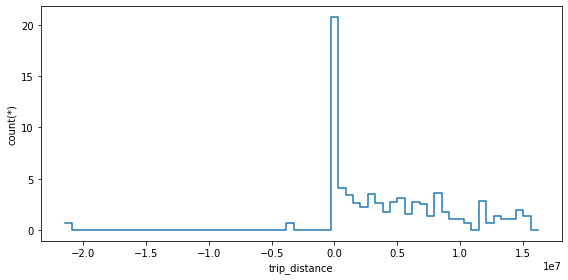

In [10]:
# Make a histograms of the trip distnaces (miles)
p.figure(figsize=(8,4))
df_train.plot1d('trip_distance', limits='minmax', f='log1p')
p.show()

In [11]:
# What is the largest distance?
_ = df_train.trip_distance.max()

print(_, 'miles.')

print('This is %3.1f times larger than the distance between the Earth and the Moon!' % (_ / 238_900))
print('or')
print('This is %1.1f the distance to Mars!' % (_ / 33_900_000))

16201631.0 miles.
This is 67.8 times larger than the distance between the Earth and the Moon!
or
This is 0.5 the distance to Mars!


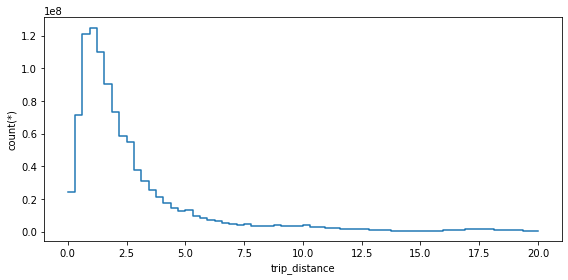

In [12]:
# Make another histogram of the trip distances, this time with a more sensible range
p.figure(figsize=(8,4))
df_train.plot1d('trip_distance', limits=[0, 20], f=None)
p.show()

In [13]:
# Filter negative and too large distances
df_train = df_train[(df_train.trip_distance>0) & (df_train.trip_distance<10)]

### What _is_ New York City really?

In [14]:
# Interactively plot the pickup locations - helps to determine the extent of NYC covered by the taxi company
df_train.plot_widget(df_train.pickup_longitude, 
                     df_train.pickup_latitude, 
                     shape=512, 
                     f='log1p', 
                     colormap='plasma', 
                     limits='minmax')

PlotTemplate(components={'main-widget': VBox(children=(VBox(children=(Figure(axes=[Axis(scale=LinearScale(allo…

In [15]:
# Define the NYC boundaries
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

In [16]:
# Make a selection based on the boundaries
df_train = df_train[(df_train.pickup_longitude > long_min)  & (df_train.pickup_longitude < long_max) & \
        (df_train.pickup_latitude > lat_min)    & (df_train.pickup_latitude < lat_max) & \
        (df_train.dropoff_longitude > long_min) & (df_train.dropoff_longitude < long_max) & \
        (df_train.dropoff_latitude > lat_min)   & (df_train.dropoff_latitude < lat_max)]

### Create some features

In [17]:
# Speed (miles per hour)
df_train['trip_speed_mph'] = df_train.trip_distance / ((df_train.dropoff_datetime - df_train.pickup_datetime) / np.timedelta64(1, 'h'))

# Time in transit (minutes)
df_train['trip_duration_min'] = (df_train.dropoff_datetime - df_train.pickup_datetime) / np.timedelta64(1, 'm')

# fare divided by distance
df_train['fare_by_distance'] = (df_train.fare_amount / df_train.trip_distance).jit_numba()

<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in less


### More filters: Trip duration

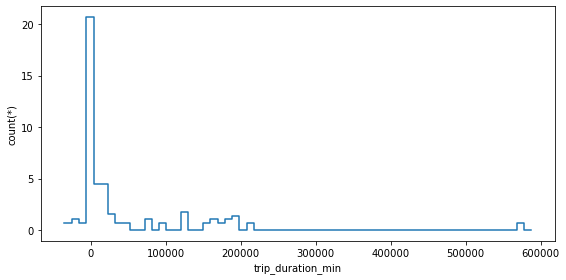

In [18]:
# Histogram of the drip durations (minutes)
p.figure(figsize=(8,4))
df_train.plot1d('trip_duration_min', f='log1p', limits='minmax')
p.show()

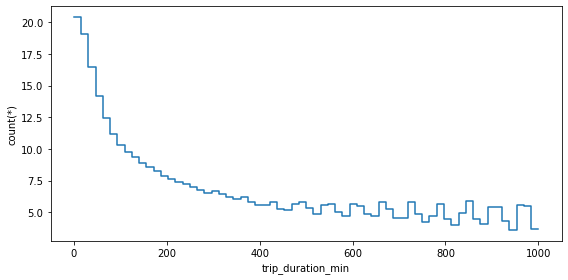

In [19]:
# Histogram of the drip durations, now with more sensible ranges
p.figure(figsize=(8,4))
df_train.plot1d('trip_duration_min', f='log1p', limits=[0, 1000])
p.show()

In [20]:
# Filter, keep durations that are within 5 hours
df_train = df_train[(df_train.trip_duration_min>0) & (df_train.trip_duration_min<120)]

### Create some date/time features

In [21]:
# Daily activities
df_train['pu_hour'] = df_train.pickup_datetime.dt.hour
df_train['pu_day_of_week'] = df_train.pickup_datetime.dt.dayofweek
df_train['pu_month'] = df_train.pickup_datetime.dt.month - 1
df_train['pu_is_weekend'] = (df_train.pu_day_of_week>=5).astype('int')

# lists to help with the labeling
weekday_names_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
month_names_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [22]:
# Treat these columns as ordinal encoded values
df_train.categorize(column='pu_hour')
df_train.categorize(column='pu_month')
df_train.categorize(column='pu_day_of_week')

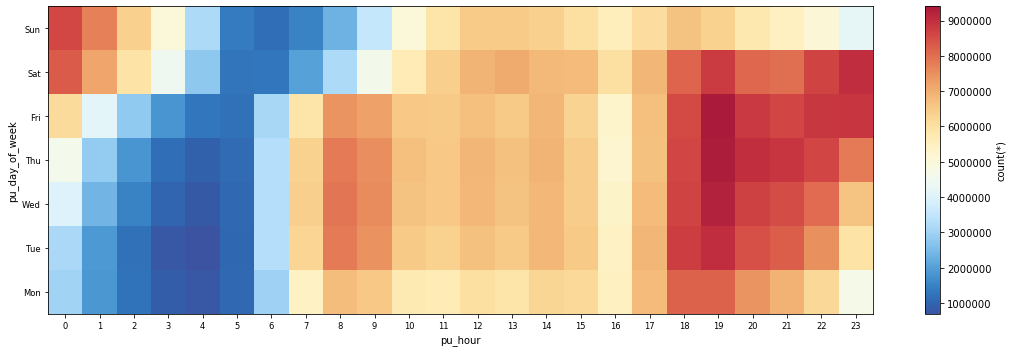

In [23]:
# Number of pick-ups per hour for a given day of the week
df_train.plot('pu_hour', 'pu_day_of_week', colorbar=True, colormap=cm_plusmin, figsize=(15, 5))
p.xticks(np.arange(24), np.arange(24))
p.yticks(np.arange(7), weekday_names_list)
p.show()

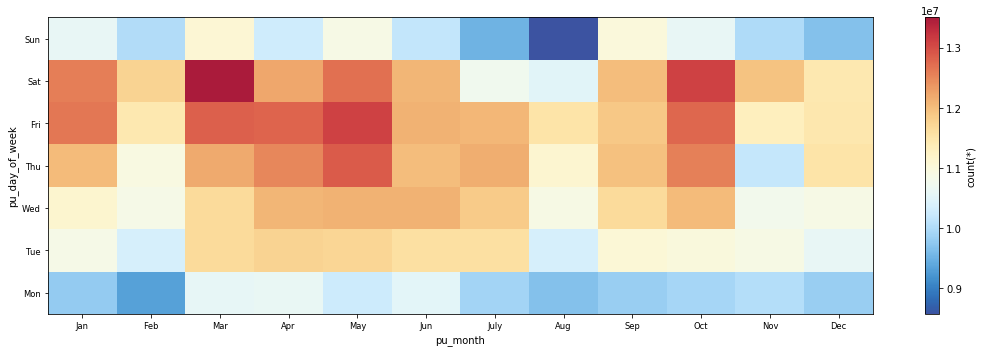

In [24]:
# Number of pick-ups per day/month 
df_train.plot('pu_month', 'pu_day_of_week', colorbar=True, colormap=cm_plusmin, figsize=(15, 5))
p.xticks(np.arange(12), month_names_list)
p.yticks(np.arange(7), weekday_names_list)
p.show()

### Groupby examples

<string>:1: RuntimeWarning: divide by zero encountered in true_divide
<string>:1: RuntimeWarning: invalid value encountered in true_divide
/Users/jovan/PyLibrary/vaex/packages/vaex-core/vaex/expression.py:848: RuntimeWarning: divide by zero encountered in f
  return self.f(*args, **kwargs)
/Users/jovan/PyLibrary/vaex/packages/vaex-core/vaex/expression.py:848: RuntimeWarning: invalid value encountered in f
  return self.f(*args, **kwargs)


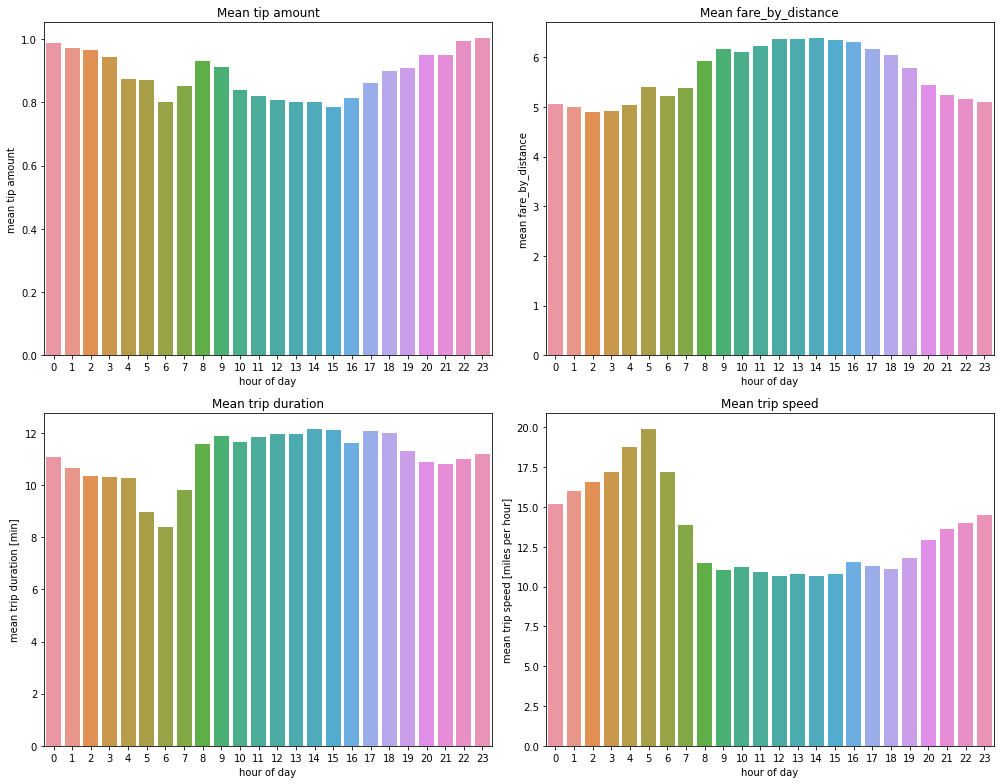

In [25]:
# Determine key statistics when the data is grouped by pickup hour
df_per_hour = df_train.groupby(by=df_train.pu_hour).agg({'fare_amount': 'mean',
                                                         'tip_amount': 'mean',
                                                         'fare_by_distance': 'mean',
                                                         'trip_duration_min': 'mean',
                                                         'trip_speed_mph': 'mean',
                                                        })

p.figure(figsize=(14, 11))

p.subplot(221)
sns.barplot(x=df_per_hour.pu_hour.values, y=df_per_hour.tip_amount.values)
p.title('Mean tip amount')
p.xlabel('hour of day')
p.ylabel('mean tip amount')

p.subplot(222)
sns.barplot(x=df_per_hour.pu_hour.values, y=df_per_hour.fare_by_distance.values)
p.title('Mean fare_by_distance')
p.xlabel('hour of day')
p.ylabel('mean fare_by_distance')

p.subplot(223)
sns.barplot(x=df_per_hour.pu_hour.values, y=df_per_hour.trip_duration_min.values)
p.title('Mean trip duration')
p.xlabel('hour of day')
p.ylabel('mean trip duration [min]')

p.subplot(224)
sns.barplot(x=df_per_hour.pu_hour.values, y=df_per_hour.trip_speed_mph.values)
p.title('Mean trip speed')
p.xlabel('hour of day')
p.ylabel('mean trip speed [miles per hour]')


p.tight_layout()
p.show()

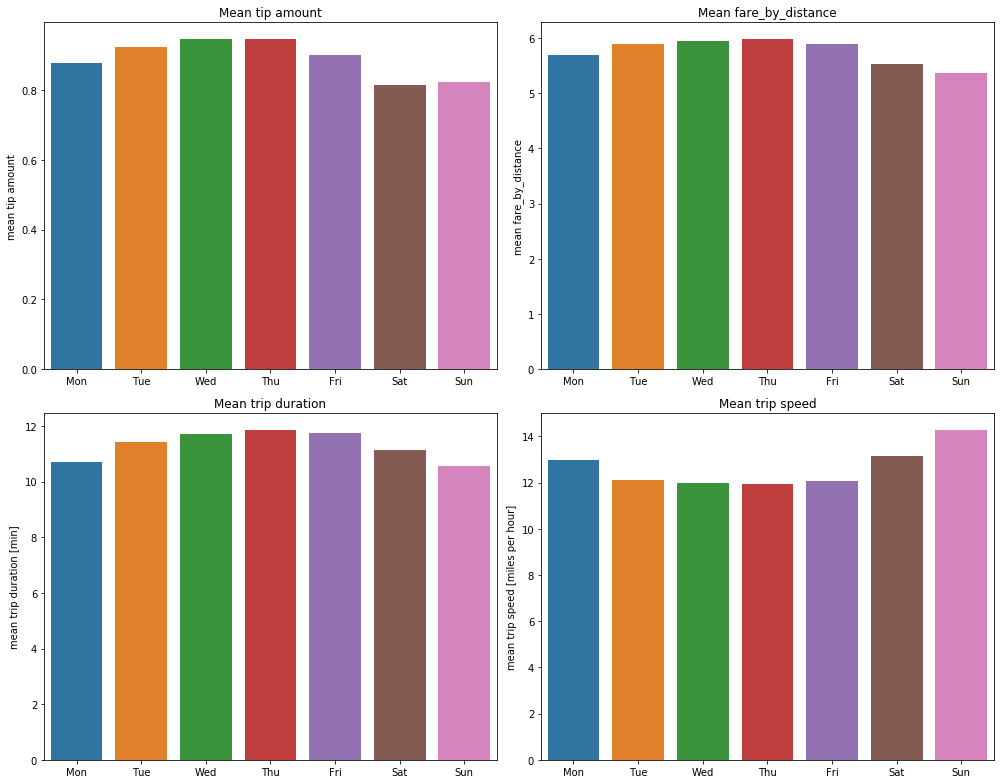

In [26]:
# Determine key statistics when the data is grouped by pickup day of the week
df_per_day = df_train.groupby(by=df_train.pu_day_of_week).agg({'fare_amount': 'mean',
                                                               'tip_amount': 'mean',
                                                               'trip_distance': 'mean',
                                                               'fare_by_distance': 'mean',
                                                               'trip_duration_min': 'mean',
                                                               'trip_speed_mph': 'mean',
                                                              })

p.figure(figsize=(14, 11))

p.subplot(221)
sns.barplot(x=df_per_day.pu_day_of_week.values, y=df_per_day.tip_amount.values)
p.title('Mean tip amount')
p.xlabel('')
p.ylabel('mean tip amount')
p.xticks(ticks=np.arange(7), labels=weekday_names_list)

p.subplot(222)
sns.barplot(x=df_per_day.pu_day_of_week.values, y=df_per_day.fare_by_distance.values)
p.title('Mean fare_by_distance')
p.xlabel('')
p.ylabel('mean fare_by_distance')
p.xticks(ticks=np.arange(7), labels=weekday_names_list)

p.subplot(223)
sns.barplot(x=df_per_day.pu_day_of_week.values, y=df_per_day.trip_duration_min.values)
p.title('Mean trip duration')
p.xlabel('')
p.ylabel('mean trip duration [min]')
p.xticks(ticks=np.arange(7), labels=weekday_names_list)

p.subplot(224)
sns.barplot(x=df_per_day.pu_day_of_week.values, y=df_per_day.trip_speed_mph.values)
p.title('Mean trip speed')
p.xlabel('')
p.ylabel('mean trip speed [miles per hour]')
p.xticks(ticks=np.arange(7), labels=weekday_names_list)


p.tight_layout()
p.show()

### Density Maps

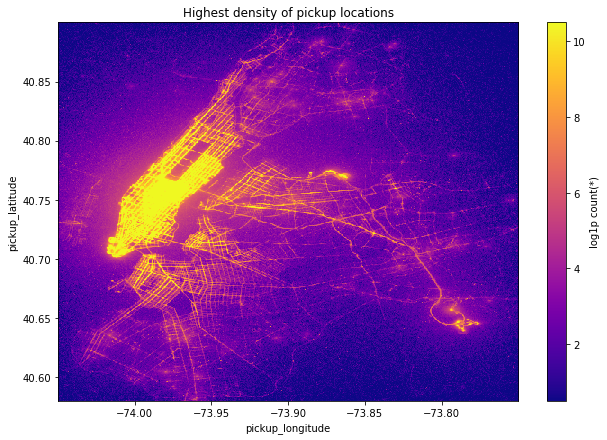

In [27]:
# Overall density map of pickup locations
p.figure(figsize=(9, 6))
df_train.plot(df_train.pickup_longitude, df_train.pickup_latitude, 
              limits='minmax',
              colorbar=True, colormap='plasma', f='log1p', shape=512, vmin=0.5, vmax=10.5)
p.title('Highest density of pickup locations')
p.show()

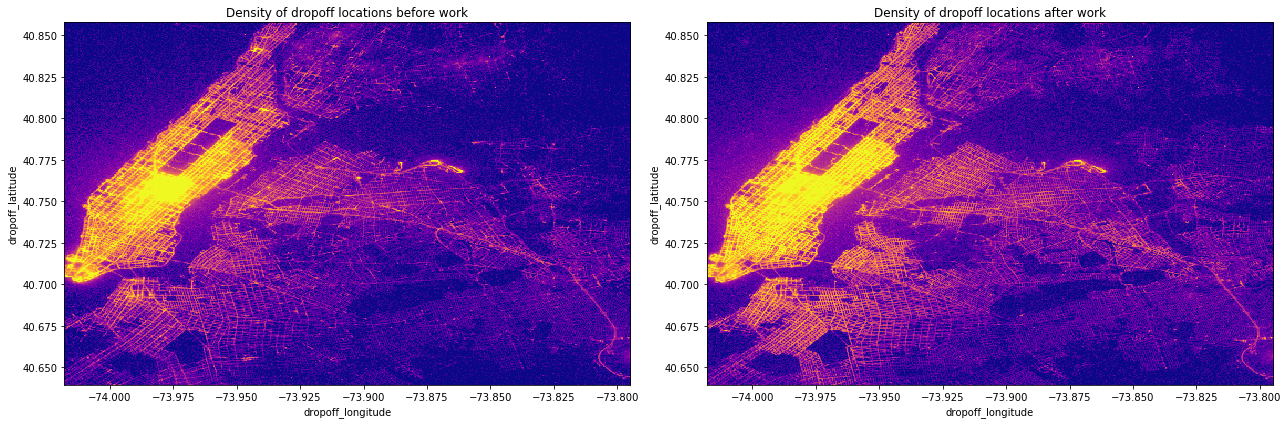

In [28]:
# Where do people go?
# Density map of dropoff locations before & after work
p.figure(figsize=(18, 6))

p.subplot(121)
df_train.plot(df_train.dropoff_longitude, df_train.dropoff_latitude,
              selection='(pu_hour>=6) & (pu_hour<9) & (pu_day_of_week<5)',
              colorbar=False, colormap='plasma', f='log1p', shape=512, vmin=0.0, vmax=9)
p.title('Density of dropoff locations before work')


p.subplot(122)
df_train.plot(df_train.dropoff_longitude, df_train.dropoff_latitude,
              selection='(pu_hour>=17) & (pu_hour<20) & (pu_day_of_week<5)',
              colorbar=False, colormap='plasma', f='log1p', shape=512, vmin=0.0, vmax=9)
p.title('Density of dropoff locations after work')

p.tight_layout()
p.show()

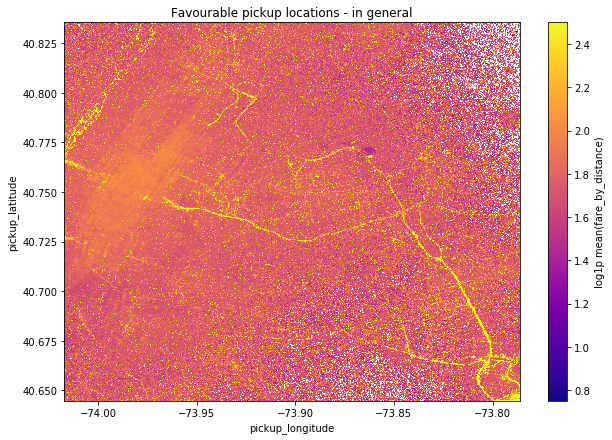

In [29]:
# Favourable pickup locations - best payout
p.figure(figsize=(9, 6))
df_train.plot(df_train.pickup_longitude, df_train.pickup_latitude, what='mean(fare_by_distance)', 
              colorbar=True, colormap='plasma', f='log1p', shape=512, vmin=0.75, vmax=2.5)
p.title('Favourable pickup locations - in general')
p.show()

## Predictive modelling example with `vaex-ml`: predict the likely duration of a taxi trip

In [30]:
import vaex.ml

### Create some computationally expensive features - can speed up with jit (numba, pythran, CUDA)

In [31]:
# arc-distance in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# distance Basel - Utrecht [miles]
arc_distance(47.5624346, 7.5909967, 52.0842715, 5.0124523)

332.8486568415132

In [32]:
# Add the arc-distance in miles as a virtual column
df_train['arc_distance_miles'] = arc_distance(df_train.pickup_longitude, df_train.pickup_latitude, 
                                              df_train.dropoff_longitude, df_train.dropoff_latitude).jit_numba()

In [33]:
# direction of travel in degrees
def direction_angle(theta_1, phi_1, theta_2, phi_2):
    dtheta = theta_2 - theta_1
    dphi = phi_2 - phi_1
    radians = np.arctan2(dtheta, dphi)
    return np.rad2deg(radians)

# The direction of travel
df_train['direction_angle'] = direction_angle(df_train.pickup_longitude, df_train.pickup_latitude, 
                                           df_train.dropoff_longitude, df_train.dropoff_latitude).jit_numba()

In [34]:
# Examine the train DataFrame at this point 
df_train.head(5)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_speed_mph,trip_duration_min,fare_by_distance,pu_hour,pu_day_of_week,pu_month,pu_is_weekend,arc_distance_miles,direction_angle
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.992,40.7216,nan,nan,-73.9938,40.6959,8.9,0.5,nan,0,0,9.4,15.78,10,3.38403,2,6,0,1,0.504949,-175.882
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.7363,nan,nan,-73.9558,40.768,12.1,0.5,nan,2,0,14.6,39,7,2.65934,3,6,0,1,1.91233,39.5963
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5,-73.9743,40.791,nan,nan,-73.9966,40.7318,14.9,0.5,nan,3.05,0,18.45,14.2631,21.0333,2.98,20,3,0,0,1.90838,-159.335
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.0016,40.7194,nan,nan,-74.0084,40.7203,3.7,0,nan,0,0,3.7,3.66412,6.55,9.25,16,5,0,1,0.470046,-81.9194
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2,-73.9898,40.735,nan,nan,-73.985,40.7245,6.1,0.5,nan,0,0,6.6,9.47368,7.6,5.08333,22,4,0,0,0.386479,155.526


### Encoding and transforming of features

In [35]:
# PCA of the pickup and dropoff locations - helps to "straighten out" the coordinates

# pickup transformations
pca_pu = vaex.ml.PCA(features=['pickup_longitude', 'pickup_latitude'], n_components=2)
df_train = pca_pu.fit_transform(df_train)

# dropoff transformations
pca_do = vaex.ml.PCA(features=['dropoff_longitude', 'dropoff_latitude'], n_components=2)
df_train = pca_do.fit_transform(df_train)

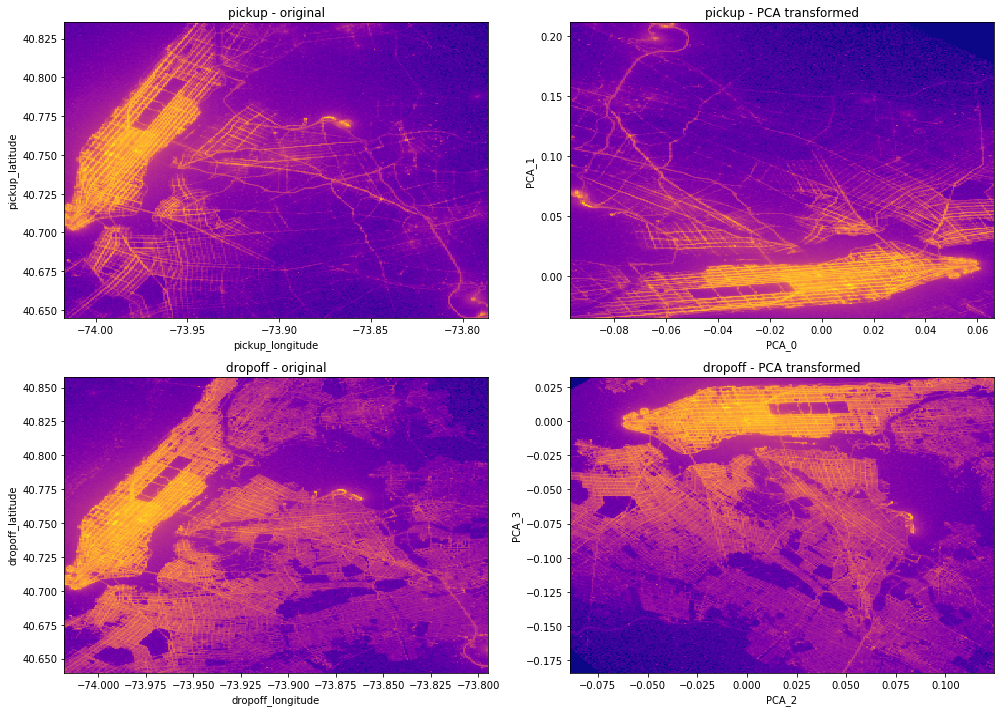

In [36]:
p.figure(figsize=(14, 10))

p.subplot(221)
p.title('pickup - original')
df_train.plot(df_train.pickup_longitude, df_train.pickup_latitude,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

p.subplot(222)
p.title('pickup - PCA transformed')
df_train.plot(df_train.PCA_0, df_train.PCA_1,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

p.subplot(223)
p.title('dropoff - original')
df_train.plot(df_train.dropoff_longitude, df_train.dropoff_latitude,
           colormap='plasma', f='log1p', shape=256, colorbar=False)

p.subplot(224)
p.title('dropoff - PCA transformed')
df_train.plot(df_train.PCA_2, df_train.PCA_3,
           colormap='plasma', f='log1p', shape=256, colorbar=False)



p.tight_layout()
p.show()

In [37]:
# Inspect the payment_type
df_train.payment_type.str.lower().value_counts(progress=True)

[########################################]:  100.00% elapsed time  :       23s =  0.4m =  0.0h                                         
 

csh          357958192
crd          346001379
cash         118143531
cas           53341764
credit        40950658
cre           28254498
unk             960561
noc             793616
no charge       365536
dis             285498
no              141147
dispute          65914
na               28525
dtype: int64

Inspect the _payment_\__type_. 
From the documentation provided:
- 1 = Credit card
- 2 = Cash
- 3 = No charge
- 4 = Dispute
- 5 = Unknown
- 6 = Voided trip

In [38]:
# Define a mapping dictionary
map_payment_type = {'csh': 2, 'crd': 1, 'cash': 2, '1': 1, 'cas': 2, '2': 2, 'credit': 1, 'cre': 1, 'unk': 5, 
                    'noc': 3, 'no charge': 3, '3':3, 'dis': 4, 'no ': 3, '4': 4, 'dispute': 4, 'na ': 5, '5':5,
                    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

df_train['payment_type_'] = df_train.payment_type.str.lower().map(map_payment_type, 
                                                                  default_value=-1, 
                                                                  allow_missing=True)

In [39]:
# inspect the DataFrame
df_train.head(5)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_speed_mph,trip_duration_min,fare_by_distance,pu_hour,pu_day_of_week,pu_month,pu_is_weekend,arc_distance_miles,direction_angle,PCA_0,PCA_1,PCA_2,PCA_3,payment_type_
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.992,40.7216,nan,nan,-73.9938,40.6959,8.9,0.5,nan,0,0,9.4,15.78,10,3.38403,2,6,0,1,0.504949,-175.882,0.0307307,0.0126046,-0.0546336,-0.0217222,2
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.7363,nan,nan,-73.9558,40.768,12.1,0.5,nan,2,0,14.6,39,7,2.65934,3,6,0,1,1.91233,39.5963,0.0133608,0.00910193,0.0255291,-0.00709981,1
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5,-73.9743,40.791,nan,nan,-73.9966,40.7318,14.9,0.5,nan,3.05,0,18.45,14.2631,21.0333,2.98,20,3,0,0,1.90838,-159.335,-0.0307173,-0.0241656,-0.0280609,0.00261327,1
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.0016,40.7194,nan,nan,-74.0084,40.7203,3.7,0,nan,0,0,3.7,3.66412,6.55,9.25,16,5,0,1,0.470046,-81.9194,0.0390948,0.00737384,-0.0444038,0.00481652,2
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2,-73.9898,40.735,nan,nan,-73.985,40.7245,6.1,0.5,nan,0,0,6.6,9.47368,7.6,5.08333,22,4,0,0,0.386479,155.526,0.0197344,0.00458446,-0.0267307,-0.0110027,2


### Setting up the predictor - `LightGBM`

In [40]:
features_lgbm = ['passenger_count', 'trip_distance', 'rate_code', 'pu_hour', 'pu_day_of_week', 'pu_is_weekend', 
                 'arc_distance_miles', 'direction_angle', 'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'payment_type_']


# the target
target = 'trip_duration_min'

In [41]:
# Import the modeling library
import vaex.ml.lightgbm # vaex.ml also supports XGBoost, CatBoost, scikit-learn, annoy, more to come)

/Users/jovan/miniconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [42]:
# parameters - standard lightgbm options
params = {
    'learning_rate': 0.1,       
    'max_depth': 5,             
    'colsample_bytree': 0.8,
    'subsample': 0.8,           
    'reg_lambda': 1,            
    'reg_alpha': 0,             
    'min_child_weight': 1,      
    'objective': 'regression',  
    'random_state': 42,         
    'n_jobs': -1} 

# Instantiate the lightgbm model wrapper 
booster = vaex.ml.lightgbm.LightGBMModel(features=features_lgbm, params=params, num_boost_round=100)

# Take small part of the training set to we can do the training in real time fast
df_train_mini = df_train[:1_000_000]

# Fit the model object
booster.fit(df_train_mini, target=target)

print('Training completed!')

Training completed!


In [43]:
# Check performance on the training set - in reality one needs to do proper (x)-validation

# Classical predict - get an in-memory array of the predictions
pred = booster.predict(df_train_mini)

# view the predictions
display(pred)

# Create a virtual column housing the predictions
df_train = booster.transform(df_train)

# view the DataFrame
df_train.head(5)

array([10.4943172 , 11.85700824, 19.62839063, ...,  8.84461919,
        6.39611876, 14.5707552 ])

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_speed_mph,trip_duration_min,fare_by_distance,pu_hour,pu_day_of_week,pu_month,pu_is_weekend,arc_distance_miles,direction_angle,PCA_0,PCA_1,PCA_2,PCA_3,payment_type_,lightgbm_prediction
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.992,40.7216,nan,nan,-73.9938,40.6959,8.9,0.5,nan,0,0,9.4,15.78,10,3.38403,2,6,0,1,0.504949,-175.882,0.0307307,0.0126046,-0.0546336,-0.0217222,2,10.4943
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.7363,nan,nan,-73.9558,40.768,12.1,0.5,nan,2,0,14.6,39,7,2.65934,3,6,0,1,1.91233,39.5963,0.0133608,0.00910193,0.0255291,-0.00709981,1,11.857
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5,-73.9743,40.791,nan,nan,-73.9966,40.7318,14.9,0.5,nan,3.05,0,18.45,14.2631,21.0333,2.98,20,3,0,0,1.90838,-159.335,-0.0307173,-0.0241656,-0.0280609,0.00261327,1,19.6284
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.0016,40.7194,nan,nan,-74.0084,40.7203,3.7,0,nan,0,0,3.7,3.66412,6.55,9.25,16,5,0,1,0.470046,-81.9194,0.0390948,0.00737384,-0.0444038,0.00481652,2,4.16829
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2,-73.9898,40.735,nan,nan,-73.985,40.7245,6.1,0.5,nan,0,0,6.6,9.47368,7.6,5.08333,22,4,0,0,0.386479,155.526,0.0197344,0.00458446,-0.0267307,-0.0110027,2,8.85233


In [44]:
# Check the performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_train_score = mean_absolute_error(df_train_mini.trip_duration_min.values, pred)
mse_train_score = mean_squared_error(df_train_mini.trip_duration_min.values, pred)

print('The mean absolute error is %2.3f' % mae_train_score)
print('The mean squared score is %2.3f' % mse_train_score)

The mean absolute error is 2.317
The mean squared score is 13.234


### Second estimator?! Let's try a simpler linear model

In [45]:
# One hot encoding of categorical features
one_hot_enc = vaex.ml.OneHotEncoder(features=['payment_type_', 
                                              'pu_hour', 
                                              'pu_day_of_week', 
                                              'pu_month'], 
                                    prefix='onehot_')

df_train = one_hot_enc.fit_transform(df_train)

In [46]:
# Standard scale some of the numerical features
standard_scaler = vaex.ml.StandardScaler(features=['arc_distance_miles', 'direction_angle', 'trip_distance'])
df_train = standard_scaler.fit_transform(df_train)

In [47]:
# view the DataFrame now
df_train.head(5)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_speed_mph,trip_duration_min,fare_by_distance,pu_hour,pu_day_of_week,pu_month,pu_is_weekend,arc_distance_miles,direction_angle,PCA_0,PCA_1,PCA_2,PCA_3,payment_type_,lightgbm_prediction,onehot_payment_type__1,onehot_payment_type__2,onehot_payment_type__3,onehot_payment_type__4,onehot_payment_type__5,onehot_pu_hour_0,onehot_pu_hour_1,onehot_pu_hour_2,onehot_pu_hour_3,onehot_pu_hour_4,onehot_pu_hour_5,onehot_pu_hour_6,onehot_pu_hour_7,onehot_pu_hour_8,onehot_pu_hour_9,onehot_pu_hour_10,onehot_pu_hour_11,onehot_pu_hour_12,onehot_pu_hour_13,onehot_pu_hour_14,onehot_pu_hour_15,onehot_pu_hour_16,onehot_pu_hour_17,onehot_pu_hour_18,onehot_pu_hour_19,onehot_pu_hour_20,onehot_pu_hour_21,onehot_pu_hour_22,onehot_pu_hour_23,onehot_pu_day_of_week_0,onehot_pu_day_of_week_1,onehot_pu_day_of_week_2,onehot_pu_day_of_week_3,onehot_pu_day_of_week_4,onehot_pu_day_of_week_5,onehot_pu_day_of_week_6,onehot_pu_month_0,onehot_pu_month_1,onehot_pu_month_2,onehot_pu_month_3,onehot_pu_month_4,onehot_pu_month_5,onehot_pu_month_6,onehot_pu_month_7,onehot_pu_month_8,onehot_pu_month_9,onehot_pu_month_10,onehot_pu_month_11,standard_scaled_arc_distance_miles,standard_scaled_direction_angle,standard_scaled_trip_distance
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.992,40.7216,nan,nan,-73.9938,40.6959,8.9,0.5,nan,0,0,9.4,15.78,10,3.38403,2,6,0,1,0.504949,-175.882,0.0307307,0.0126046,-0.0546336,-0.0217222,2,10.4943,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.614416,-1.56023,0.189254
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.7363,nan,nan,-73.9558,40.768,12.1,0.5,nan,2,0,14.6,39,7,2.65934,3,6,0,1,1.91233,39.5963,0.0133608,0.00910193,0.0255291,-0.00709981,1,11.857,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.490347,0.537361,1.22485
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5,-73.9743,40.791,nan,nan,-73.9966,40.7318,14.9,0.5,nan,3.05,0,18.45,14.2631,21.0333,2.98,20,3,0,0,1.90838,-159.335,-0.0307173,-0.0241656,-0.0280609,0.00261327,1,19.6284,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.487246,-1.39915,1.46757
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.0016,40.7194,nan,nan,-74.0084,40.7203,3.7,0,nan,0,0,3.7,3.66412,6.55,9.25,16,5,0,1,0.470046,-81.9194,0.0390948,0.00737384,-0.0444038,0.00481652,2,4.16829,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.641814,-0.645546,-1.01355
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2,-73.9898,40.735,nan,nan,-73.985,40.7245,6.1,0.5,nan,0,0,6.6,9.47368,7.6,5.08333,22,4,0,0,0.386479,155.526,0.0197344,0.00458446,-0.0267307,-0.0110027,2,8.85233,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.707412,1.66589,-0.582053


In [48]:
# Try a linear model
import vaex.ml.sklearn
from sklearn.linear_model import LinearRegression

In [49]:
# Specify which features to use
features_linear = ['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'pu_is_weekend'] + \
                  [feature for feature in df_train.get_column_names() if 'standard_scaled_' in feature] + \
                  [feature for feature in df_train.get_column_names() if 'onehot_' in feature]

In [50]:
# Instantiate the vaex-sklearn model wrapper
linear_model = vaex.ml.sklearn.SKLearnPredictor(model=LinearRegression(copy_X=False, n_jobs=-1), 
                                                features=features_linear, prediction_name='linear_prediction')

# Agaom, take small part of the training so we can train in real time.
df_train_mini = df_train[:1_000_000]


# Fit the model object
linear_model.fit(df_train_mini, target=target)

print('Training completed!')

Training completed!


In [51]:
# Check performance on the training set - in reality one needs to do proper (x)-validation

# Classical predict - get an in-memory array of the predictions
pred_linear = linear_model.predict(df_train_mini)

# view the predictions
display(pred_linear)

# Create a virtual column housing the predictions
df_train = linear_model.transform(df_train)

# view the DataFrame 
df_train.head(5)

array([ 9.09023576, 13.0823256 , 18.55664037, ...,  9.64341342,
        7.96064327, 11.91514913])

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_speed_mph,trip_duration_min,fare_by_distance,pu_hour,pu_day_of_week,pu_month,pu_is_weekend,arc_distance_miles,direction_angle,PCA_0,PCA_1,PCA_2,PCA_3,payment_type_,lightgbm_prediction,onehot_payment_type__1,onehot_payment_type__2,onehot_payment_type__3,onehot_payment_type__4,onehot_payment_type__5,onehot_pu_hour_0,onehot_pu_hour_1,onehot_pu_hour_2,onehot_pu_hour_3,onehot_pu_hour_4,onehot_pu_hour_5,onehot_pu_hour_6,onehot_pu_hour_7,onehot_pu_hour_8,onehot_pu_hour_9,onehot_pu_hour_10,onehot_pu_hour_11,onehot_pu_hour_12,onehot_pu_hour_13,onehot_pu_hour_14,onehot_pu_hour_15,onehot_pu_hour_16,onehot_pu_hour_17,onehot_pu_hour_18,onehot_pu_hour_19,onehot_pu_hour_20,onehot_pu_hour_21,onehot_pu_hour_22,onehot_pu_hour_23,onehot_pu_day_of_week_0,onehot_pu_day_of_week_1,onehot_pu_day_of_week_2,onehot_pu_day_of_week_3,onehot_pu_day_of_week_4,onehot_pu_day_of_week_5,onehot_pu_day_of_week_6,onehot_pu_month_0,onehot_pu_month_1,onehot_pu_month_2,onehot_pu_month_3,onehot_pu_month_4,onehot_pu_month_5,onehot_pu_month_6,onehot_pu_month_7,onehot_pu_month_8,onehot_pu_month_9,onehot_pu_month_10,onehot_pu_month_11,standard_scaled_arc_distance_miles,standard_scaled_direction_angle,standard_scaled_trip_distance,linear_prediction
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.992,40.7216,nan,nan,-73.9938,40.6959,8.9,0.5,nan,0,0,9.4,15.78,10,3.38403,2,6,0,1,0.504949,-175.882,0.0307307,0.0126046,-0.0546336,-0.0217222,2,10.4943,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.614416,-1.56023,0.189254,9.09024
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.7363,nan,nan,-73.9558,40.768,12.1,0.5,nan,2,0,14.6,39,7,2.65934,3,6,0,1,1.91233,39.5963,0.0133608,0.00910193,0.0255291,-0.00709981,1,11.857,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.490347,0.537361,1.22485,13.0823
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5,-73.9743,40.791,nan,nan,-73.9966,40.7318,14.9,0.5,nan,3.05,0,18.45,14.2631,21.0333,2.98,20,3,0,0,1.90838,-159.335,-0.0307173,-0.0241656,-0.0280609,0.00261327,1,19.6284,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.487246,-1.39915,1.46757,18.5566
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.0016,40.7194,nan,nan,-74.0084,40.7203,3.7,0,nan,0,0,3.7,3.66412,6.55,9.25,16,5,0,1,0.470046,-81.9194,0.0390948,0.00737384,-0.0444038,0.00481652,2,4.16829,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.641814,-0.645546,-1.01355,6.25763
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2,-73.9898,40.735,nan,nan,-73.985,40.7245,6.1,0.5,nan,0,0,6.6,9.47368,7.6,5.08333,22,4,0,0,0.386479,155.526,0.0197344,0.00458446,-0.0267307,-0.0110027,2,8.85233,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.707412,1.66589,-0.582053,7.74905


In [52]:
mae_train_score = mean_absolute_error(df_train_mini.trip_duration_min.values, pred_linear)
mse_train_score = mean_squared_error(df_train_mini.trip_duration_min.values, pred_linear)

print('The mean absolute error is %2.3f' % mae_train_score)
print('The mean squared score is %2.3f' % mse_train_score)

The mean absolute error is 2.902
The mean squared score is 18.534


### Ensemble?!

In [53]:
# Average the predictions from the Gradient Boosting and Linear models
df_train['final_prediction'] = (df_train.lightgbm_prediction + df_train.linear_prediction) / 2

In [54]:
### Display the DataFrame
df_train.head(5)

#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,trip_speed_mph,trip_duration_min,fare_by_distance,pu_hour,pu_day_of_week,pu_month,pu_is_weekend,arc_distance_miles,direction_angle,PCA_0,PCA_1,PCA_2,PCA_3,payment_type_,lightgbm_prediction,onehot_payment_type__1,onehot_payment_type__2,onehot_payment_type__3,onehot_payment_type__4,onehot_payment_type__5,onehot_pu_hour_0,onehot_pu_hour_1,onehot_pu_hour_2,onehot_pu_hour_3,onehot_pu_hour_4,onehot_pu_hour_5,onehot_pu_hour_6,onehot_pu_hour_7,onehot_pu_hour_8,onehot_pu_hour_9,onehot_pu_hour_10,onehot_pu_hour_11,onehot_pu_hour_12,onehot_pu_hour_13,onehot_pu_hour_14,onehot_pu_hour_15,onehot_pu_hour_16,onehot_pu_hour_17,onehot_pu_hour_18,onehot_pu_hour_19,onehot_pu_hour_20,onehot_pu_hour_21,onehot_pu_hour_22,onehot_pu_hour_23,onehot_pu_day_of_week_0,onehot_pu_day_of_week_1,onehot_pu_day_of_week_2,onehot_pu_day_of_week_3,onehot_pu_day_of_week_4,onehot_pu_day_of_week_5,onehot_pu_day_of_week_6,onehot_pu_month_0,onehot_pu_month_1,onehot_pu_month_2,onehot_pu_month_3,onehot_pu_month_4,onehot_pu_month_5,onehot_pu_month_6,onehot_pu_month_7,onehot_pu_month_8,onehot_pu_month_9,onehot_pu_month_10,onehot_pu_month_11,standard_scaled_arc_distance_miles,standard_scaled_direction_angle,standard_scaled_trip_distance,linear_prediction,final_prediction
0,VTS,2009-01-04 02:52:00.000000000,2009-01-04 03:02:00.000000000,1,CASH,2.63,-73.992,40.7216,nan,nan,-73.9938,40.6959,8.9,0.5,nan,0,0,9.4,15.78,10,3.38403,2,6,0,1,0.504949,-175.882,0.0307307,0.0126046,-0.0546336,-0.0217222,2,10.4943,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.614416,-1.56023,0.189254,9.09024,9.79228
1,VTS,2009-01-04 03:31:00.000000000,2009-01-04 03:38:00.000000000,3,Credit,4.55,-73.9821,40.7363,nan,nan,-73.9558,40.768,12.1,0.5,nan,2,0,14.6,39,7,2.65934,3,6,0,1,1.91233,39.5963,0.0133608,0.00910193,0.0255291,-0.00709981,1,11.857,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.490347,0.537361,1.22485,13.0823,12.4697
2,DDS,2009-01-01 20:52:58.000000000,2009-01-01 21:14:00.000000000,1,CREDIT,5,-73.9743,40.791,nan,nan,-73.9966,40.7318,14.9,0.5,nan,3.05,0,18.45,14.2631,21.0333,2.98,20,3,0,0,1.90838,-159.335,-0.0307173,-0.0241656,-0.0280609,0.00261327,1,19.6284,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.487246,-1.39915,1.46757,18.5566,19.0925
3,DDS,2009-01-24 16:18:23.000000000,2009-01-24 16:24:56.000000000,1,CASH,0.4,-74.0016,40.7194,nan,nan,-74.0084,40.7203,3.7,0,nan,0,0,3.7,3.66412,6.55,9.25,16,5,0,1,0.470046,-81.9194,0.0390948,0.00737384,-0.0444038,0.00481652,2,4.16829,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.641814,-0.645546,-1.01355,6.25763,5.21296
4,DDS,2009-01-16 22:35:59.000000000,2009-01-16 22:43:35.000000000,2,CASH,1.2,-73.9898,40.735,nan,nan,-73.985,40.7245,6.1,0.5,nan,0,0,6.6,9.47368,7.6,5.08333,22,4,0,0,0.386479,155.526,0.0197344,0.00458446,-0.0267307,-0.0110027,2,8.85233,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.707412,1.66589,-0.582053,7.74905,8.30069


In [55]:
mae_train_score = mean_absolute_error(df_train[:1_000_000].trip_duration_min.values, 
                                      df_train[:1_000_000].final_prediction.values)
mse_train_score = mean_squared_error(df_train[:1_000_000].trip_duration_min.values, 
                                     df_train[:1_000_000].final_prediction.values)

print('The mean absolute error is %2.3f' % mae_train_score)
print('The mean squared score is %2.3f' % mse_train_score)

The mean absolute error is 2.517
The mean squared score is 14.857


### So what about a pipeline?

## The `vaex` `state` – all the pipeline you need!

All the operations which were performed so are in fact expressions. These can be saved, and applied to another DataFrame. In other words, a pipeline is automatically being created behind the scenes while one is exploring and experimenting with the data!

In [56]:
# Save the state to disk
state = df_train.state_write('./data/taxi_ml_state.json')